In [ ]:
#cd ~/magnus/

In [1]:
###### outputPath = os.path.join(os.path.abspath("."),"test_fric/")
import underworld as uw
import math
from underworld import function as fn
import glucifer
import numpy as np
import os
import matplotlib.pyplot as plt
from unsupported.LMR import *
import unsupported.scaling as sca
from unsupported.scaling import nonDimensionalize as nd
from decimal import *
import cv2

uw.matplotlib_inline()
# use low resolution if running in serial

u = sca.UnitRegistry

# Define scale criteria
tempMin = 273.*u.degK 
tempMax = (1400.+ 273.)*u.degK
bodyforce = 3300 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2
#velocity = 1.*u.centimeter/u.year
velocity = 1e-9*u.meter/u.second

KL = 100e3*u.meter
Kt = KL/velocity
KT = tempMax 
KM = bodyforce * KL**2 * Kt**2
K  = 1.*u.mole
lengthScale = 100e3

sca.scaling["[length]"] = KL
sca.scaling["[time]"] = Kt
sca.scaling["[mass]"]= KM
sca.scaling["[temperature]"] = KT
sca.scaling["[substance]"] = K

gravity = nd(9.81 * u.meter / u.second**2)
R = nd(8.3144621 * u.joule / u.mole / u.degK)
step=0

outputPath = os.path.join(os.path.abspath("."),"landsliding_randtest/")

if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
uw.barrier()

fo = open(outputPath+"dicMesh"+str(step).zfill(4),'r')
meshDic=eval(fo.read())

'''
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = meshDic['elements'], 
                                 minCoord    = meshDic['minCoord'], 
                                 maxCoord    = meshDic['maxCoord'],
                                 ) 
'''
xRes=meshDic['elements'][0]
yRes=meshDic['elements'][1]
dim  = 2  
mesh = uw.mesh.FeMesh_Cartesian( elementType = (("Q1/dQ0")), 
                                 elementRes  = ( xRes, yRes), 
                                 ) 
mesh.load(outputPath+"mesh"+str(step).zfill(4))

minX = min(mesh.data[:,0])
maxX = max(mesh.data[:,0])
minY = min(mesh.data[:,1])
maxY = max(mesh.data[:,1])

mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (xRes, yRes), 
                                 minCoord    = (minX, minY), 
                                 maxCoord    = (maxX, maxY),
                                 periodic    = [False, False]) 



/home/haibin/underworld/unsupported/scaling/__init__.py:13: UserWarning: 

    The scaling module is not supported.

    It requires 'pint' as a dependency.

    You can install pint by running:

    'pip install pint' in a terminal

    Questions should be addressed to romain.beucher@unimelb.edu.au 
 
  Questions should be addressed to romain.beucher@unimelb.edu.au \n """


In [2]:
vis_factor = nd(1*u.pascal*u.second)
vel_factor = nd(1*u.centimeter/u.year)
stress_factor = nd(1*u.pascal)
strainRate_factor = nd(1/u.second)
temp_factor = nd(1*u.degK)

In [ ]:
def visPlot(step):
    vis= uw.mesh.MeshVariable(mesh=mesh,nodeDofCount=1)
    velField = uw.mesh.MeshVariable(mesh=mesh,nodeDofCount=2)


    velField.load(outputPath+'velocityField'+str(step).zfill(4))
    vis.load(outputPath+'meshViscosity'+str(step).zfill(4))

    fo = open(outputPath+"time"+str(step).zfill(4),"r")
    t = fo.read()
    time_factor = nd(1*u.megayear)
    time = float(t)/time_factor 
    time = Decimal(time).quantize(Decimal('1.000'))

    vel = uw.mesh.MeshVariable(mesh=mesh,nodeDofCount=2)
    vel.data[:,0]=1*velField.data[:,0]
    vel.data[:,1]=1*velField.data[:,1]
    fig = glucifer.Figure(title="Time="+str(time)+"Myr"+"  "+"Viscosity", figsize=(800,500),quality=3,
                                    margin = 120, rulers = True, rulerticks= 5 )
    surf=glucifer.objects.Surface( mesh, fn.math.log10(vis/vis_factor), valueRange=[20,24],colours="white blue grey" ) 
    #surf=glucifer.objects.Surface( mesh.subMesh, fn.math.log10(pr/stress_factor),colours="red white blue" ) 
    #fig.append(glucifer.objects.Mesh( mesh )) 
    #fig.append(glucifer.objects.Surface( mesh, fn.math.log10(strainRate), valueRange=[-17,-13],colours="blue white red" ) )
    fig.append(surf)

    fig.append(glucifer.objects.VectorArrows( mesh, vel/vel_factor, scaling=5e-2,arrowHead =10,resolutionI=20, resolutionJ=21))
    #fig.append(glucifer.objects.Surface(mesh, vel/vel_factor,colours="blue white red ") )
    

    fig.script('scale y 1')
    surf.colourBar["align"] = "right"
    surf.colourBar["position"] = 150
    surf.colourBar["size"] = [0.4,0.02]
    surf.colourBar["tickvalues"] = [18,19,20,21,22,23]
    #fig.save('/home/haibin/Desktop/landslide/F4C2e6Vis24Point200/'+'Vis'+str(step).zfill(4)+'.png')
    fig.show()

In [ ]:
visPlot(1)

In [ ]:
def prPlot(step):

    pr = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

    pr.load(outputPath+'pressureField'+str(step).zfill(4))

    fo = open(outputPath+"time"+str(step).zfill(4),"r")
    t = fo.read()
    time_factor = nd(1*u.megayear)
    time = float(t)/time_factor 
    time = Decimal(time).quantize(Decimal('1.000'))

    fig = glucifer.Figure(title="Time="+str(time)+"Myr"+"  "+"Pressure", figsize=(800,800),quality=3,
                                    margin = 100, rulers = True, rulerticks= 5 )
    surf=glucifer.objects.Surface( mesh.subMesh, fn.math.log10(pr/stress_factor),colours="red white blue" ) 

    fig.append(surf)
    

    fig.script('scale y 1')
    surf.colourBar["align"] = "right"
    surf.colourBar["position"] = 150
    surf.colourBar["size"] = [0.4,0.02]
    #surf.colourBar["tickvalues"] = [18,19,20,21,22,23]
    #fig.save('/home/haibin/Desktop/Silo/VisEla/'+'Vis'+str(step).zfill(4)+'.png')
    fig.show()

In [ ]:
prPlot(100)

In [ ]:

i = 1
nc = 100
tt1 = np.zeros((nc,1))
Time = np.zeros((nc,1))
while i < nc:
    step=i*20
    
    fo = open(outputPath+"time"+str(step).zfill(4),"r")
    t = fo.read()
    time_factor = nd(1*u.kiloyear)
    time = float(t)/time_factor 
    time = Decimal(time).quantize(Decimal('1.0'))
    Time[i] = time
    velField = uw.mesh.MeshVariable(mesh=mesh,nodeDofCount=2)


    velField.load(outputPath+'velocityField'+str(step).zfill(4))
    vel = uw.mesh.MeshVariable(mesh=mesh,nodeDofCount=1)
    vel.data[:,0]=velField.data[:,1]
    '''
    meshDevStress = uw.mesh.MeshVariable( mesh, 1 )
    meshDevStress.load(outputPath+"meshElasticStress"+str(step).zfill(4))
    meshDevStress = sca.Dimensionalize(meshDevStress, units=u.pascal)
    '''

    
    count = 1
    locations1 = np.zeros( (count,2))
    locations1[:,0] = 0.0 #np.linspace(-0.2,0.2,count)
    locations1[:,1] = 0.1
    tt1[i]= vel.evaluate(locations1)
    
    i+= 1




xx = np.linspace(-0.2,0.2,count)
plt.plot(Time[1:],tt1[1:])
plt.xlabel("Time $[kyr]$")
plt.ylabel("Velocity $[cm/yr]$")
#pyplot.plot(xx,tt1/vel_factor,'r*')
#pyplot.plot(xx,tt2/vel_factor,'bo')data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAZQAAAEOCAYAAACuOOGFAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAHP1JREFUeJzt3X+YXVV97/H3J5n84CKBREKIQAhglB/ye0RRsVaiBawGf1HQ1tgLpmL1sc996DVIb+u11gqt2qtw26aKBMQqipS0ghBSHr0ioYQA4UeABISamDAhCIRKJplzvvePvSc5mZwf+8zZ+5yd4fN6nvPMPnv2Oft79sys76y19lpLEYGZmVmnxvU6ADMzGxucUMzMLBdOKGZmlgsnFDMzy4UTipmZ5cIJxczMcuGEYmZmuXBCMTOzXDihmJlZLvp6HUDR9t9//5g9e3avwzAz26Pcc889z0TE9HZeM+YTyuzZs1mxYkWvwzAz26NIeqrd17jJy8zMcuGEYmZmuXBCMTOzXDihmJlZLpxQzMwsF6VKKJLOkPSopLWSFtb5/iRJ30u/f5ek2d2P0szM6ilNQpE0HrgCOBM4GjhP0tEjDjsf+HVEvBr4KnBpd6M0M7NGyjQO5RRgbUQ8ASDpu8A84OGaY+YBn0u3fwBcLklRknWMn3zmv7jh3vV0FI7UUQydvbrJ+7Z449F+5A4/bumpsJ/ITkH7F7/TuIZ/bp3+5Y0m9ka6ca2zyPMzNdPo89b+TR04ZTLnvP6QrsQD5UooBwG/rHm+DnhDo2MiYkjS88ArgWdqD5K0AFgAMGvWrKLi3cXzL23nD668i18++9KoC8lypEUzGytOOGS/l21CyU1ELAIWAfT39xdeTEcEC69fxYbntnL9hW/i5EOnFn3Krspa41KbmbQkFcvCdPPjtXPpO69VjDh3Z2+XSy01z2sdlOMzNdPo8/b6L6pMCWU9UJtKD0731TtmnaQ+YF9gc3fCa+ya5U9x84MbufjMI8dcMoH2E0Wv37csyvrxyhpXJ8biZ2qmrJ+3NJ3ywN3AHEmHSZoInAssGXHMEmB+uv0B4N973X/y4Prn+cK/rea3Xzudj512eC9DMTPrqdLUUNI+kU8CtwDjgSsj4iFJnwdWRMQS4JvANZLWAs+SJJ2euuL2tewzuY8vn3MC48aV9N8GM7MuKE1CAYiIm4CbRuz785rtrcAHux1XM+ufe4ljDtqXaXtP7HUoZmY9VaYmrz3SwAuDHLDPpF6HYWbWc04oHahWg2dedEIxMwMnlI48+5ttDFXDCcXMDCeUjgy8MAjAAVMm9zgSM7Pec0LpwMCWrQCuoZiZ4YTSkYEtaQ1lH9dQzMycUDqwaTihTHENxczMCaUDAy9sZZ/JfUyeML7XoZiZ9ZwTSgcGtviWYTOzYU4oHUgSivtPzMzACaUjA1u2uv/EzCzlhDJKEeFpV8zMajihjNILW4cYHKq6ycvMLOWEMkqbhgc1usnLzAxwQhm14WlXprvJy8wMcEIZNY+SNzPblRPKKA24ycvMbBdOKKM08MIgkyeMY59JpVr00sysZ5xQRml4UKPkdeTNzMAJZdQ2edoVM7NdOKGMkkfJm5ntyglllDyPl5nZrpxQRmHr9gpbtg55DIqZWQ0nlFHYsZa8E4qZ2Q5OKKMwPAbFNRQzs52cUEbBo+TNzHZXioQiaZqkpZLWpF+n1jnmBEl3SnpI0ipJv9eLWCFZ+hc8St7MrFYpEgqwEFgWEXOAZenzkX4DfCQijgHOAP5O0n5djHGHgS2D9I0T0/7bxF6c3syslMqSUOYBi9PtxcDZIw+IiMciYk26/StgAJjetQhrDGwZZP9XTGLcOI+SNzMbVpaEMiMiNqTbG4EZzQ6WdAowEXi8wfcXSFohacWmTZvyjZR0DIqbu8zMdtG1mQ0l3QYcWOdbl9Q+iYiQFE3eZyZwDTA/Iqr1jomIRcAigP7+/obvNRqVavD4wIsc/aopeb6tmdker2sJJSLmNvqepKclzYyIDWnCGGhw3BTgR8AlEbG8oFCb+vGDG1n/3EtcfNaRvTi9mVlplaXJawkwP92eD9w48gBJE4EbgKsj4gddjG2HiODr/76Gw6fvzZmvm9mLEMzMSqssCeVLwDskrQHmps+R1C/pG+kx5wBvBT4q6b70cUI3g1y2eoBHNm7hj9/2asa7Q97MbBelWB0qIjYDp9fZvwK4IN3+NvDtLodWGwtfv30tB0/di/ec8KpehWFmVlplqaGU3h1rN3P/L5/jwrcdwYTxvmxmZiO5ZMzo8tvXMGPKJD5w8sG9DsXMrJScUDJa+dRzvPu4VzGpb3yvQzEzKyUnlAyq1WBbpcrek0rR5WRmVkpOKBlsqyTjJydN8OUyM2vEJWQGg0NJQpnozngzs4ZcQmYwOFQBYNIE95+YmTXihJLBtrSGMqnPl8vMrBGXkBkMOqGYmbXkEjKDwe1OKGZmrbiEzGD4Lq+JTihmZg25hMxgcHvaKe9BjWZmDTmhZOAaiplZay4hM3AfiplZay4hM3ANxcysNZeQGewY2Og+FDOzhpxQMhge2OgaiplZYy4hM/DARjOz1lxCZuAaiplZay4hM3ANxcystZYrRkmaluF9qhHxXA7xlJKnrzczay3LEoS/Sh9qcsx4YFYuEZXQ4FCFiX3jkJpdAjOzl7csCWV1RJzY7ABJ9+YUTykNbq+6ucvMrIUspeSpksZJ+myzY/IKqIy2VZxQzMxaaVlKRsTWiKgC7252TK5RlUxSQ/GgRjOzZtr5t/t+SX8h6WX3r/q2StW3DJuZtdBOKTkNOBf4laQbJf2lpA/mEYSkaZKWSlqTfp3a5NgpktZJujyPc2cxuL3iJi8zsxYyl5IRcU5EHAUcCvxvYC1wSk5xLASWRcQcYFn6vJG/BH6a03kzcQ3FzKy1zKVkWnM4PiIGI2JlRCyOiD/NKY55wOJ0ezFwdoMYTgZmALfmdN5MfJeXmVlr7ZSSnwH+TtK3JM3MOY4ZEbEh3d5IkjR2kfbdfBm4KOdzt+QaiplZa1nGoQAQESuB35b0fuDHkn4IXBYRL2V5vaTbgAPrfOuSEecJSVHnuE8AN0XEulYDDCUtABYAzJrV+XjLwaEK++41oeP3MTMbyzInFAAlJfmjwN8DXwA+JuniiLim1WsjYm6T931a0syI2JDWfgbqHHYqcJqkTwCvACZKejEidutviYhFwCKA/v7+esmpLduGqp52xcyshXb6UO4A1gNfBQ4CPgq8DThF0qIO41gCzE+35wM3jjwgIj4cEbMiYjZJs9fV9ZJJEQaHqkya4IRiZtZMlskhTwWWkzQhPRwRI//j/5Sk1R3G8SXgOknnA08B56Tn7gc+HhEXdPj+Hdk25E55M7NWsjR5fQS4AniMpO/kxxGxccQx7+okiIjYDJxeZ/8KYLdkEhFXAVd1cs52DA65U97MrJWWCSUiLgSQdCRwJnCVpH2B24EfA3dExBOFRtljycBGT71iZtZMOwMbH4mIr0bEGcDbgZ8BHwTuKiq4svBtw2ZmrbV7l9eEiNie3ip8U/oY06rVYHsl3IdiZtZC5oQi6RvAuyQNkSy4tQpYFRFfLyq4MthW8XryZmZZtFNDOQ04OCIqkg4CjgeOKyas8hjcPryevPtQzMyaaSeh3AW8EhiIiPUkY1LGfJPXYKUCuIZiZtZKO6XkPwI/kXSRpNPSO73GvJ01FCcUM7Nm2iklvw1cTVKr+QTwc0mPFxJViQz3oTihmJk1106T17qI+OvaHZIm5RxP6biGYmaWTTul5H2SPl27IyIGc46ndHbWUNwpb2bWTDs1lBnAXEmfAVYC9wP3RcT3C4msJAa3u1PezCyLdhLKZcAjwHbgGOBYkiWAx3RCcR+KmVk27SSUq4GT0maulZL+E9hcTFjlMdyH4hqKmVlz7ZSSWyNi6/CTiHgG+Hz+IZWL+1DMzLJpJ6E8IenMEfsm5hlMGQ0OuQ/FzCyLdpq8PgXcLOkPSBbcOgYY8+NQfNuwmVk27UxfvwE4GbgemE4yOeSHCoqrNDw5pJlZNm1NXx8RFZKEcn0x4ZSPayhmZtm0LCUlrczjmD2VayhmZtlkqaEcJWlVk+8LGLMTRe4Y2DjeCcXMrJksCeXIDMdUOg2krAbT5X8l9ToUM7NSa5lQIuKpbgRSVoPbq+4/MTPLwCVlC9sqVQ9qNDPLwAmlBddQzMyyyVxSSvqUpKlFBlNGSQ3FCcXMrJV2SsoZwN2SrpN0hl4mvdSD2yu+ZdjMLIN2Rsr/GTAH+CbwUWCNpC9KOqLTICRNk7RU0pr0a92akKRZkm6VtFrSw5Jmd3ruVlxDMTPLpq2SMiIC2Jg+hoCpwA8kXdZhHAuBZRExB1iWPq/nauBvIuIokrVYBjo8b0uD26uuoZiZZdBOH8qnJd1DstDWHcCxEXEhyfxe7+8wjnnA4nR7MXB2nfMfDfRFxFKAiHgxIn7T4XlbGhyq+C4vM7MM2pnLaxrwvpHjUiKiKul3O4xjRjr5JCS1nxl1jnkN8JykHwKHAbcBC9P5xQqzrVJlP9dQzMxaaqeknDwymUi6FCAiVrd6saTbJD1Y5zGv9ri0WS3qvEUfcBpwEfB64HCSvpx651ogaYWkFZs2bcry2RrybcNmZtm0U1K+o86+kQtuNRQRcyPidXUeNwJPS5oJkH6t1zeyDrgvIp6IiCHgX4CTGpxrUUT0R0T/9OnTs4ZY17aK+1DMzLLIMtvwhZIeAF4raVXN4xcka6LkYQkwP92eD9xY55i7gf0kDWeItwMP53T+hlxDMTPLJksfyneAm4G/Zte7r7ZExLM5xfEl4DpJ5wNPAecASOoHPh4RF0RERdJFwLJ0DMw9wD/ldP6GPPWKmVk2WSaHfB54HjivqCAiYjNwep39K4ALap4vBY4rKo56PLDRzCyblglF0s8i4i2StrBrZ7lI+tCnFBZdCXhgo5lZNllqKG9Jv+5TfDjlEhFsrwQTvLiWmVlLLimbGKomFbK+cS+LacvMzDrSzkj5xZL2q3k+VdKVxYRVDpU0oYxzQjEza6mdGspxEfHc8JOI+DVwYv4hlUc1koQy3gnFzKyldhLKuNpZgCVNo72pW/Y4wzWU8S+PmfrNzDrSTkL4MnCnpO+T3OH1AeCvComqJHYkFNdQzMxaypxQIuJqSStIRqgHyUSRhY9U7yUnFDOz7NptsppAUjsZ3h7TKuFOeTOzrNpaDwW4FtgfOAD4tqRPFRVYGVSryVf3oZiZtdZODeV84A0R8V+wY+r6O4GvFxFYGQzXUDwOxcystXbu8hJQu5hVhZ3NX2NSpeImLzOzrNqpoXwLuEvSDenzs4Fv5h9SeVR2jEPpcSBmZnuAdu7y+oqknwBvTnf9YUTcW0xY5bBjpLz7UMzMWmrrLq+IuIdkHZKXheqOPhRXUczMWskyfX3ttPUauT2Wp68fqrjJy8wsqyzT17/spq0fNlxDcZOXmVlr7YxDkaTfl/S/0ueHSDqluNB6zyPlzcyya6cx5/8CpwIfSp+/CFyRe0Ql4pHyZmbZtdMp/4aIOEnSvZBMXy9pYkFxlULFC2yZmWXWTg1lu6TxpJ3ykqYD1UKiKglPX29mll07CeVrwA3AAZL+CvgZ8MVCoiqJqldsNDPLLMttw1cA34mIayXdA5xOcsvw2RGxuugAe6niFRvNzDLL0ofyGPC3kmYC1wH/PNZHyA/zXV5mZtm1bPKKiP8TEacCvwVsBq6U9Iikv5D0msIj7CH3oZiZZZe5DyUinoqISyPiROA8kskhx3aTl2soZmaZtTOwsU/SuyVdC9wMPAq8L48gJE2TtFTSmvTr1AbHXSbpIUmrJX1NKrbq4JHyZmbZtUwokt4h6UpgHfAx4EfAERFxbkTcmFMcC4FlETEHWJY+HxnHm0hmOj4OeB3wepJmuMJU0pui+8Y7oZiZtZKlhnIx8HPgqIh4T0R8Z3jVxhzNAxan24tJmtNGCmAyMBGYRLKm/dM5x7GLoXQNYNdQzMxayzI55Nu7EMeMiNiQbm8EZtSJ405JtwMbSG5bvrzo25arvm3YzCyzttZD6YSk24AD63zrktonERGSYuRBkl4NHAUcnO5aKum0iPh/dY5dACwAmDVr1qhjHm7y8l1eZmatdS2hRMTcRt+T9LSkmRGxIR3vMlDnsPcCyyPixfQ1N5NMVrlbQomIRcAigP7+/t2SU1Y7R8qP9h3MzF4+ylJULgHmp9vzgXqd/f8J/FZ6t9kEkg75Qpu8hqpesdHMLKuylJRfAt4haQ0wN32OpH5J30iP+QHwOPAAcD9wf0T8a5FB7Zy+vsizmJmNDV1r8momIjaTzBE2cv8K4IJ0uwL8UTfjqnqkvJlZZv7fuwmPlDczy84JpQknFDOz7JxQmvD09WZm2TmhNDFcQ/FIeTOz1pxQmqi6ycvMLDMnlCZ2NHm5hmJm1pITShOVaiB5TXkzsyycUJqoVMO1EzOzjJxQmqhEuHZiZpaRE0oT1WrQ54RiZpaJE0oTQ27yMjPLzAmliWrVTV5mZlk5oTRRifAYFDOzjJxQmqhUPUrezCwrJ5QmKtWqO+XNzDJyQmmiUvW0K2ZmWTmhNFGN8GqNZmYZubhswiPlzcyyc0Jpwnd5mZll54TSRKXihGJmlpUTShOVCN82bGaWkRNKE9WqayhmZlk5oTRRCU8OaWaWlRNKExXP5WVmlpkTShO+bdjMLDsnlCZcQzEzy84JpYlquIZiZpZVKRKKpA9KekhSVVJ/k+POkPSopLWSFhYd11A16BvvhGJmlkUpEgrwIPA+4KeNDpA0HrgCOBM4GjhP0tFFBlWtehyKmVlWfb0OACAiVgOoeeF9CrA2Ip5Ij/0uMA94uKi4PPWKmVl2ZamhZHEQ8Mua5+vSfbuRtEDSCkkrNm3aNOoTeoEtM7PsulZDkXQbcGCdb10SETfmea6IWAQsAujv74/Rvk+16oGNZmZZdS2hRMTcDt9iPXBIzfOD032FGapW3eRlZpbRntTkdTcwR9JhkiYC5wJLijxhNfA4FDOzjEqRUCS9V9I64FTgR5JuSfe/StJNABExBHwSuAVYDVwXEQ8VGVcyUr7IM5iZjR1lucvrBuCGOvt/BZxV8/wm4KZuxVWpBuO9BrCZWSYuLZtIEkqvozAz2zO4uGzC41DMzLJzQmnCI+XNzLJzQmnCC2yZmWXnhNJEpeLp683MsnJCaaLi6evNzDJzQmkiucvLCcXMLAsnlCaq4SYvM7OsnFCaGPLkkGZmmTmhNBARRHj6ejOzrJxQGqhUk1nv3YdiZpaNE0oDlXBCMTNrhxNKA9Vq8tUJxcwsGyeUBobSjOJxKGZm2TihNDBcQ/Ftw2Zm2TihNLCjD8X5xMwsEyeUBvrGi3cdO5PZ++/d61DMzPYIpVixsYymTJ7AFR8+qddhmJntMVxDMTOzXDihmJlZLpxQzMwsF04oZmaWCycUMzPLhROKmZnlwgnFzMxy4YRiZma5UKRTjIxVkjYBT43y5fsDz+QYTp4c2+iVOT7HNjpljg3KHV+j2A6NiOntvNGYTyidkLQiIvp7HUc9jm30yhyfYxudMscG5Y4vz9jc5GVmZrlwQjEzs1w4oTS3qNcBNOHYRq/M8Tm20SlzbFDu+HKLzX0oZmaWC9dQzMwsF04odUg6Q9KjktZKWtiD8x8i6XZJD0t6SNKn0/2fk7Re0n3p46ya11ycxvuopN/pQoxPSnogjWNFum+apKWS1qRfp6b7JelraXyrJBW20Iyk19Zcn/skvSDpT3p17SRdKWlA0oM1+9q+TpLmp8evkTS/4Pj+RtIjaQw3SNov3T9b0ks11/Afal5zcvr7sDb9DB2vddogtrZ/jkX8PTeI7Xs1cT0p6b50f7evW6Pyo/jfu4jwo+YBjAceBw4HJgL3A0d3OYaZwEnp9j7AY8DRwOeAi+ocf3Qa5yTgsDT+8QXH+CSw/4h9lwEL0+2FwKXp9lnAzYCANwJ3dfFnuRE4tFfXDngrcBLw4GivEzANeCL9OjXdnlpgfO8E+tLtS2vim1173Ij3+Y80ZqWf4cyCYmvr51jU33O92EZ8/8vAn/foujUqPwr/vXMNZXenAGsj4omI2AZ8F5jXzQAiYkNErEy3twCrgYOavGQe8N2IGIyIXwBrST5Ht80DFqfbi4Gza/ZfHYnlwH6SZnYhntOBxyOi2cDWQq9dRPwUeLbOOdu5Tr8DLI2IZyPi18BS4Iyi4ouIWyNiKH26HDi42XukMU6JiOWRlERX13ymXGNrotHPsZC/52axpbWMc4B/bvYeBV63RuVH4b93Tii7Owj4Zc3zdTQvzAslaTZwInBXuuuTabX0yuEqK72JOYBbJd0jaUG6b0ZEbEi3NwIzehgfwLns+kddlmvX7nXq5e/kfyf573XYYZLulfQTSael+w5KY+pWfO38HHtx7U4Dno6INTX7enLdRpQfhf/eOaGUmKRXANcDfxIRLwB/DxwBnABsIKlW98pbIuIk4EzgjyW9tfab6X9cPbuFUNJE4D3A99NdZbp2O/T6OjUj6RJgCLg23bUBmBURJwL/A/iOpCldDquUP8cRzmPXf2R6ct3qlB87FPV754Syu/XAITXPD073dZWkCSS/DNdGxA8BIuLpiKhERBX4J3Y2zXQ95ohYn34dAG5IY3l6uCkr/TrQq/hIEt3KiHg6jbM01472r1PXY5T0UeB3gQ+nhQ9pc9LmdPsekr6J16Sx1DaLFRbfKH6OXb12kvqA9wHfq4m569etXvlBF37vnFB2dzcwR9Jh6X+55wJLuhlA2gb7TWB1RHylZn9tv8N7geE7TJYA50qaJOkwYA5JZ19R8e0taZ/hbZJO3AfTOIbvBJkP3FgT30fSu0neCDxfU/Uuyi7/JZbl2tWcs53rdAvwTklT0yaed6b7CiHpDOB/Au+JiN/U7J8uaXy6fTjJtXoijfEFSW9Mf3c/UvOZ8o6t3Z9jt/+e5wKPRMSOpqxuX7dG5Qfd+L3r9I6CsfgguevhMZL/JC7pwfnfQlIdXQXclz7OAq4BHkj3LwFm1rzmkjTeR8nhTpEW8R1OcrfM/cBDw9cIeCWwDFgD3AZMS/cLuCKN7wGgv+D49gY2A/vW7OvJtSNJahuA7SRt0OeP5jqR9GWsTR9/WHB8a0nazod/9/4hPfb96c/7PmAl8O6a9+knKdwfBy4nHTRdQGxt/xyL+HuuF1u6/yrg4yOO7fZ1a1R+FP5755HyZmaWCzd5mZlZLpxQzMwsF04oZmaWCycUMzPLhROKmZnlwgnFzMxy4YRiZma5cEIxG0HSK7Vz7YqN2nX9jYmSfl7AOXesmZE+P13SNaN8r73SWLdJ2j/fSM0a6+t1AGZlE8m8SydAsqAT8GJE/G3NIW8q6NSPR8QJ6fbxwL2jfJ9tEXGCpCfzCcssG9dQzNok6cW0RvGIpKskPSbpWklzJd2hZHW7U2qO/31J/5HWGv5xeF6nFo4H7k3nprpK0hclHVtbO5J0kqRl6fb30/deDlyc+4c2y8AJxWz0Xk0yffqR6eNDJPMoXQR8FkDSUcDvAW9Oax8V4MMZ3vs4ktlgbwFui4jPkswHdXhNQvoK8Kfp9rEka3C8MSK+kMNnM2ubm7zMRu8XEfEAgKSHgGUREZIeIFn2FZJVI08G7k4mgWUvdk4bXlc69fjhJBMQ/lFE3AkQEdX0PMdImgM8FRErJU0mWab183l/QLN2OKGYjd5gzXa15nmVnX9bAhZHRDvNUEeRTLs+jaRGU2s58GbgE+xcjvUYknXAhzDrITd5mRVrGfABSQcASJom6dAWrzke+DnJ2h3fkjSj5nvLgS8AN0S6yBlJc9eqfMM2a58TilmBIuJh4M+AWyWtApYCM5u/iuOBByPiMeAzwHVpMxjAIyQ1oUtrjndCsVLweihmJSBpNvBvEfG6FsddDtwdEYszvOeTJIslPZNHjGatuIZiVg4VYN/hgY0jSTpC0iPAXq2SyfDARmACSX+OWVe4hmJmZrlwDcXMzHLhhGJmZrlwQjEzs1w4oZiZWS6cUMzMLBdOKGZmlgsnFDMzy4UTipmZ5eL/A3VpvHgeWI8jAAAAAElFTkSuQmCC
#plt.savefig('/home/haibin/Desktop/Silo/Vis/'+'VelPoint10000Kyr'+'.png',dpi=300)

plt.show()

In [ ]:
step = 1000
swarmCopy = uw.swarm.Swarm( mesh=mesh )
swarmCopy.load(outputPath+'swarm'+str(step).zfill(4))
prStress = swarmCopy.add_variable("double",3)
prStress.load(outputPath+"previousStress"+str(step).zfill(4))
figMeshDevStress =  glucifer.Figure(title="Time="+str(time)+"Myr",figsize=(600,1000),quality=3,
                                margin = 50, rulers = True, rulerticks= 5 )
surf = glucifer.objects.Points( swarmCopy,fn.math.log10(prStress[1]/stress_factor),valueRange=(4,7),colours="blue white yellow red")
figMeshDevStress.append(surf )
#arrowMin = glucifer.objects.VectorArrows( mesh, stressMax_Vector , scaling=2e-1, arrowHead=1,resolutionI=23, resolutionJ=23)
#figMeshDevStress.append(arrowMin)
figMeshDevStress.script('scale x 1')
surf.colourBar["size"] = [0.5,0.02]
surf.colourBar["tickvalues"] = [1]
surf.colourBar["align"] = "right"
surf.colourBar["position"] = 150

#figMeshDevStress.save('/home/haibin/Desktop/CplxTest/'+'Fault3PStrain'+str(step).zfill(4)+'.png')

figMeshDevStress.show()

In [ ]:
step = 1000


fo = open(outputPath+"time"+str(step).zfill(4),"r")
t = fo.read()
time_factor = nd(1*u.kiloyear)
time = float(t)/time_factor 
time = Decimal(time).quantize(Decimal('1.0'))
velField = uw.mesh.MeshVariable(mesh=mesh,nodeDofCount=2)


velField.load(outputPath+'velocityField'+str(step).zfill(4))
vel = uw.mesh.MeshVariable(mesh=mesh,nodeDofCount=1)
vel.data[:,0]=velField.data[:,1]


count = 100
locations1 = np.zeros( (count,2))
locations1[:,0] = np.linspace(-0.2,0.2,count)
locations1[:,1] = 0.05


tt1 = vel.evaluate(locations1)

locations1[:,1] = 0.1
tt2 = vel.evaluate(locations1)

locations1[:,1] = 0.2
tt3 = vel.evaluate(locations1)

locations1[:,1] = 0.3
tt4 = vel.evaluate(locations1)

xx = np.linspace(-0.2,0.2,count)
fig,ax=plt.subplots(figsize=(10,5))
plt.plot(xx,tt1/vel_factor,'-^',markersize=10,label='Y = 0.0',Alpha=0.7)
plt.plot(xx,tt2/vel_factor,'-s',markersize=10,label='Y = 0.1',Alpha=0.6)
plt.plot(xx,tt3/vel_factor,'-*',markersize=10,label='Y = 0.2',Alpha=0.4)
plt.plot(xx,tt4/vel_factor,'-o',markersize=10,label='Y = 0.3',Alpha=0.2)

plt.xlabel("X")
plt.ylabel("Velocity $[cm/yr]$")
plt.title("Time = "+str(time)+" kyr")
plt.legend()
plt.savefig('/home/haibin/Desktop/Silo/VisEla/'+'VelProfile'+str(step) +'.png',dpi=300)


plt.show()

In [ ]:
def tempPlot(step):
    temp= uw.mesh.MeshVariable(mesh=mesh,nodeDofCount=1)
    temp.load(outputPath+'temperatureField'+str(step).zfill(4))



    fo = open(outputPath+"time"+str(step).zfill(4),"r")
    t = fo.read()
    time_factor = nd(1*u.megayear)
    time = float(t)/time_factor 
    time = Decimal(time).quantize(Decimal('1.000'))

    fig = glucifer.Figure(title="Time="+str(time)+"Myr"+"  "+"Viscosity", figsize=(800,300),quality=3,
                                    margin = 100, rulers = True, rulerticks= 5 )
    surf=glucifer.objects.Surface( mesh, temp/temp_factor,colours="red white blue" ) 
    #fig.append(glucifer.objects.Mesh( mesh )) 
    #fig.append(glucifer.objects.Surface( mesh, fn.math.log10(strainRate), valueRange=[-17,-13],colours="blue white red" ) )
    fig.append(surf)

    #fig.append(glucifer.objects.VectorArrows( mesh, vel/vel_factor, scaling=8e-4,arrowHead =10,resolutionI=10, resolutionJ=21))
    #fig.append(glucifer.objects.Surface(mesh, vel/vel_factor,colours="blue white red ") )
    

    fig.script('scale y 2')
    surf.colourBar["align"] = "right"
    surf.colourBar["position"] = 150
    surf.colourBar["size"] = [0.4,0.02]
    surf.colourBar["tickvalues"] = [19.5]
    #fig.save('/home/haibin/Desktop/Boudary Effect/'+'ViscosityL400400Grd10'+str(step).zfill(4)+'.png')
    fig.show()

In [ ]:
tempPlot(1300)

In [ ]:
import matplotlib.pyplot as pyplot
step1 = 100
step2 = 700
temp= uw.mesh.MeshVariable(mesh=mesh,nodeDofCount=1)
temp.load(outputPath+'temperatureField'+str(step1).zfill(4))
count = 100
locations1 = np.zeros( (count,2))
locations1[:,0] = 1
locations1[:,1] = np.linspace(0.,1,count)
tt1= temp.evaluate(locations1)
temp= uw.mesh.MeshVariable(mesh=mesh,nodeDofCount=1)
temp.load(outputPath+'temperatureField'+str(step2).zfill(4))


tt2 = temp.evaluate(locations1)


xx = locations1[:,1]
pyplot.plot(tt1*1773-273,xx*700-680,'r*')
pyplot.plot(tt2*1773-273,xx*700-680,'bo')

#pyplot.plot((120e3-xx),TT1-273,'r*')
#pyplot.plot((120e3-xx),TT2-273,'bo')

pyplot.show()

In [ ]:
def strainRatePlot(step):

    velField = uw.mesh.MeshVariable(mesh=mesh,nodeDofCount=2)
    velField.load(outputPath+'velocityField'+str(step).zfill(4))

    
    
    fo = open(outputPath+"time"+str(step).zfill(4),"r")
    t = fo.read()
    time_factor = nd(1*u.megayear)
    time = float(t)/time_factor
    
    strainRateFn = fn.tensor.symmetric( velField.fn_gradient )
    strainRate_2ndInvariant = fn.tensor.second_invariant(strainRateFn)
    #fig = glucifer.Figure(title="Time="+str(time)+"Myr"+"  "+"Strainrate",figsize=(600,800),quality=3,
     #                               margin = 100, rulers = True, rulerticks= 5 )
    fig = glucifer.Figure(figsize=(800,500),quality=3,
                                    margin = 80, rulers = True, rulerticks= 5 )
    #fig.append(glucifer.objects.Mesh( mesh )) 
    surf=glucifer.objects.Surface( mesh, fn.math.log10(strainRate_2ndInvariant/strainRate_factor),colours="black grey white" ) 
    fig.append(surf)
    #fig.append(glucifer.objects.VectorArrows( mesh, velField, scaling=5e-1,arrowHead=5,resolutionI=24, resolutionJ=15))

    fig.script('scale x 1')
    #surf.colourBar["tickvalues"] = [-15,]
    #fig.save('/home/haibin/Desktop/Silo/Pr0e5Vis24strainRate/'+'strainRate'+str(step).zfill(4)+'.png')
    fig.show()
    #valueRange=(-13.5,-12),

In [ ]:
strainRatePlot(100)

In [3]:
#def radonPlot(step):
step = 15
from skimage.transform import radon, iradon
'''
velField = uw.mesh.MeshVariable(mesh=mesh,nodeDofCount=2)
velField.load(outputPath+'velocityField'+str(step).zfill(4))


strainRateFn = fn.tensor.symmetric( velField.fn_gradient )
strainRate_2ndInvariant = fn.tensor.second_invariant(strainRateFn)
strainRate = strainRate_2ndInvariant.evaluate(mesh)
strainRate = np.reshape(strainRate,(yRes+1,xRes+1))[::-1]
'''

swarmCopy = uw.swarm.Swarm( mesh=mesh )
swarmCopy.load(outputPath+'swarm'+str(step).zfill(4))
plasticStrainCopy = swarmCopy.add_variable("double",1)
plasticStrainCopy.load(outputPath+"plasticStrain0"+str(step).zfill(4))
meshPlasticStrain= uw.mesh.MeshVariable( mesh, 1 )
projectorPlasticStrain = uw.utils.MeshVariable_Projection( meshPlasticStrain,plasticStrainCopy, type=1)
projectorPlasticStrain.solve()



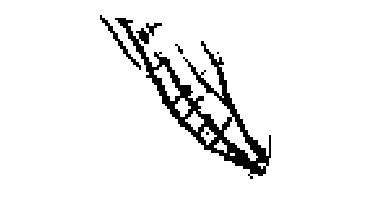

In [61]:
im = np.reshape(meshPlasticStrain.data,(yRes+1,xRes+1))[::-1]
im = np.where(( im > 0.01), 1, 0)
fig, ax1 = plt.subplots()
neg1=ax1.imshow(im , cmap='Greys' )
ax1.set_aspect('equal')
#fig.colorbar(neg1, ax=ax1,orientation="horizontal")
ax1.axis('off')
plt.savefig('/home/haibin/Desktop/'+'plasticStrain'+str(step).zfill(4)+'.png')

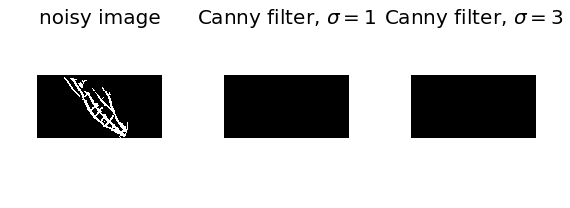

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature



im = np.where(( im > 0.01 ), 1, 0)
# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im, sigma=1e-1)
edges2 = feature.canny(im, sigma=1e2)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()


In [39]:
im.shape

(65, 129)

In [ ]:
img = cv2.imread('/home/haibin/Desktop/plasticStrain0015.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]

cv2.imshow('dst',img)
if cv2.waitKey(0) & 0xff == 27:
    cv2.destroyAllWindows()

In [ ]:
img.shape

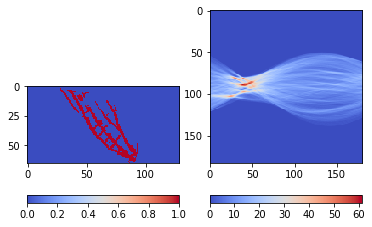

In [35]:
im = np.reshape(meshPlasticStrain.data,(yRes+1,xRes+1))[::-1]
im = im = np.where(( im > 0.01 ), 1, 0)
projections = radon(im,circle=False)
fig, (ax1,ax2) = plt.subplots(1,2)
neg1=ax1.imshow(im , cmap='coolwarm' )
ax1.set_aspect('equal')
fig.colorbar(neg1, ax=ax1,orientation="horizontal")


neg2=ax2.imshow(projections , cmap='coolwarm' )
ax2.set_aspect(1./ax2.get_data_ratio())
fig.colorbar(neg2, ax=ax2,orientation="horizontal")

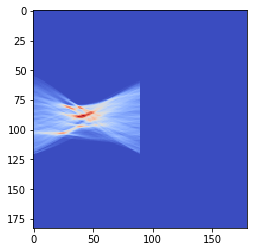

In [36]:
projections2 = projections
projections2[:,90:]=0

plt.imshow(projections2, cmap='coolwarm' )
plt.show()


/usr/local/lib/python2.7/dist-packages/skimage/transform/radon_transform.py:204: UserWarning: The default of `circle` in `skimage.transform.iradon` will change to `True` in version 0.15.
  warn('The default of `circle` in `skimage.transform.iradon` '


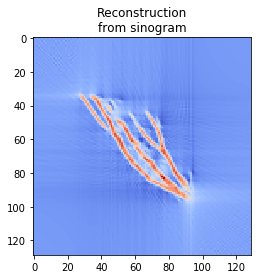

In [37]:
reconstruction = iradon(projections2)

plt.title("Reconstruction\nfrom sinogram")
plt.imshow(reconstruction, cmap='coolwarm' )

plt.show()

In [ ]:
def curlPlot(step):

    velField = uw.mesh.MeshVariable(mesh=mesh,nodeDofCount=2)
    velField.load(outputPath+'velocityField'+str(step).zfill(4))

    
    
    fo = open(outputPath+"time"+str(step).zfill(4),"r")
    t = fo.read()
    time_factor = nd(1*u.megayear)
    time = float(t)/time_factor
    
    curl = fn.tensor.antisymmetric(velField.fn_gradient )

    #fig = glucifer.Figure(title="Time="+str(time)+"Myr"+"  "+"Strainrate",figsize=(600,800),quality=3,
     #                               margin = 100, rulers = True, rulerticks= 5 )
    fig = glucifer.Figure(figsize=(800,500),quality=3,
                                    margin = 80, rulers = True, rulerticks= 5 )
    #fig.append(glucifer.objects.Mesh( mesh )) 
    surf=glucifer.objects.Surface( mesh, (curl[1]),colours="black grey white" ) 
    fig.append(surf)
    #fig.append(glucifer.objects.VectorArrows( mesh, velField, scaling=5e-1,arrowHead=5,resolutionI=24, resolutionJ=15))

    fig.script('scale x 1')
    #surf.colourBar["tickvalues"] = [-15,]
    #fig.save('/home/haibin/Desktop/landslide/curl/'+'curl'+str(step).zfill(4)+'.png')
    fig.show()
    #valueRange=(-13.5,-12),



In [ ]:
curlPlot(15)

In [ ]:
max(curl[:,1])

In [ ]:
step = 0
velField = uw.mesh.MeshVariable(mesh=mesh,nodeDofCount=2)
velField.load(outputPath+'velocityField'+str(step).zfill(4))


count = 650


locations1 = np.zeros( (count,2))
locations1[:,0] = np.linspace(minX,maxX,count) 
locations1[:,1] = 2.

locations2 = np.zeros( (count,2))
locations2[:,0] = -0.7
locations2[:,1] = np.linspace(minY,maxY,count) 

TT1= velField.evaluate(locations1)
TT2= velField.evaluate(locations2)

xx1 = locations1[:,0]/1e3
xx2 = locations2[:,1]/1e3
tt1 = TT1/vel_factor
tt2 = TT2/vel_factor

#plt.plot(xx1,tt1[:,0],'bo')
plt.subplot(121)
plt.plot(xx1,tt1[:,1],'bo')
plt.subplot(122)
plt.plot(xx2,tt2[:,1],'bo')

plt.show()

In [ ]:
def stressPlot(step):
    
    fo = open(outputPath+"time"+str(step).zfill(4),"r")
    t = fo.read()
    time_factor = nd(1*u.megayear)
    time = float(t)/time_factor
    
    velField = uw.mesh.MeshVariable(mesh=mesh,nodeDofCount=2)
    vis = uw.mesh.MeshVariable(mesh=mesh,nodeDofCount=1)

    velField.load(outputPath+'velocityField'+str(step).zfill(4))
    vis.load(outputPath+'meshViscosity'+str(step).zfill(4))
    
    stressTensor  = uw.mesh.MeshVariable( mesh=mesh,  nodeDofCount=6 )
    strainRateFn = fn.tensor.symmetric(velField.fn_gradient )
    devStressFn = 2.0 * vis*strainRateFn   
    
    stress_factor = nd(1*u.pascal)
    stressMapFn = 2.0 *vis* strainRateFn/stress_factor
    
    meshDevStress = uw.mesh.MeshVariable( mesh, 1 )
    meshDevStress.load(outputPath+"meshElasticStress"+str(step).zfill(4))
    meshDevStress = sca.Dimensionalize(meshDevStress, units=u.pascal)

    figMeshDevStress= glucifer.Figure(title="time="+str(time)+"Myr"+"  "+"Stress",figsize=(800,500),quality=3,
                                    margin = 100, rulers = True, rulerticks= 11 )
    #figMeshDevStress.append( glucifer.objects.Surface(mesh,fn.math.log10(fn.math.abs(stressMapFn[0])),colours="blue white red") )
    surf = glucifer.objects.Surface(mesh,fn.math.log10((meshDevStress)),valueRange=(4,7), colours="blue yellow red white") 
    figMeshDevStress.append( surf)
    figMeshDevStress.script('scale x 1')
    surf.colourBar["tickvalues"] = [4,5,6]
    figMeshDevStress.show()

In [ ]:
stressPlot(300)

In [ ]:
stressPlot(1000)

In [ ]:
def materialPlot(step): 
    fo = open(outputPath+"time"+str(step).zfill(4),"r")
    t = fo.read()
    time_factor = nd(1*u.megayear)
    time = float(t)/time_factor
    
    vis= uw.mesh.MeshVariable(mesh=mesh,nodeDofCount=1)
    velField = uw.mesh.MeshVariable(mesh=mesh,nodeDofCount=2)
    vel = uw.mesh.MeshVariable(mesh=mesh,nodeDofCount=2)
    
    velField.load(outputPath+'velocityField'+str(step).zfill(4))
    vel.data[:,0]=1*velField.data[:,0]
    vel.data[:,1]=1*velField.data[:,1]
    
    swarmCopy = uw.swarm.Swarm( mesh=mesh )
    swarmCopy.load(outputPath+'swarm'+str(step).zfill(4))
    materialIndexCopy = swarmCopy.add_variable("int",1)
    materialIndexCopy.load(outputPath+'materialVariable'+str(step).zfill(4))
    
    deformationSwarm1 = uw.swarm.Swarm( mesh=mesh )
    deformationSwarm1.load(outputPath+"deformationSwarm1"+str(step).zfill(4))
    '''
    deformationSwarm2 = uw.swarm.Swarm( mesh=mesh )
    deformationSwarm2.load(outputPath+"deformationSwarm2"+str(step).zfill(4))
    '''
    fig = glucifer.Figure( title="time="+str(time)+"Myr",figsize=(800,500),quality=3,
                                    margin = 100, rulers = True, rulerticks= 5 )
    
    #fig.append(glucifer.objects.Mesh( mesh )) 
    #fig.append(glucifer.objects.Surface( mesh, fn.math.log10(strainRate), valueRange=[-17,-13],colours="blue white red" ) )
    surf1 = glucifer.objects.Points( deformationSwarm1, 1,pointSize=5,colours="blue " )
    #fig.append(surf1)
    fig.append(glucifer.objects.Points( swarmCopy, materialIndexCopy,pointSize=3,colours="grey white" ) ) 

    #surf2 = glucifer.objects.Points( deformationSwarm2, 1,pointSize=3,colours="blue" ) 
    
    #fig.append(surf2)
    
    fig.append(glucifer.objects.VectorArrows( mesh, vel/vel_factor, scaling=1e-2,arrowHead =10,resolutionI=15, resolutionJ=21))
    
    fig.script('scale y 1')
    '''
    surf1.colourBar["align"] = "right"
    surf1.colourBar["position"] = 200
    surf1.colourBar["size"] = [0.4,0.02]
    '''

    
    #surf.colourBar["tickvalues"] = [18,19,20,21,22]
    
    fig.show()


In [ ]:
 materialPlot(300)

pressure = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
pressure.load(outputPath+"pressureField"+str(step).zfill(4)) 
figPressure= glucifer.Figure( figsize=(1000,900),quality=3, margin=150, rulers=True, rulerticks=9 )
figPressure.append( glucifer.objects.Surface(mesh,fn.math.log10(pressure), colours="blue yellow red white") 
                  )
figPressure.show()

In [ ]:
def stressTensorPlot(step):
    from numpy.linalg import eig,solve,lstsq
    fo = open(outputPath+"time"+str(step).zfill(4),"r")
    t = fo.read()
    time_factor = nd(1*u.megayear)
    time = float(t)/time_factor
    time = Decimal(time).quantize(Decimal('1.000'))
    
    swarmCopy = uw.swarm.Swarm( mesh=mesh )
    swarmCopy.load(outputPath+'swarm'+str(step).zfill(4))
    velField = uw.mesh.MeshVariable(mesh=mesh,nodeDofCount=2)
    vis= uw.mesh.MeshVariable(mesh=mesh,nodeDofCount=1)

    velField.load(outputPath+'velocityField'+str(step).zfill(4))
    vis.load(outputPath+'meshViscosity'+str(step).zfill(4))
    
    stressTensor  = uw.mesh.MeshVariable( mesh=mesh,  nodeDofCount=6 )
    strainRateFn = fn.tensor.symmetric(velField.fn_gradient )
    devStressFn = 2.0 * strainRateFn
    stress  = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=3*3 )
    stressEig  = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=3 )
    stressAngle  = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=3 )
    angleLeft = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=4 )
    angleRight = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
    ratioAngle = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
    theta = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
    cosX = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
    cosY = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
    cosZ = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

    # In[3]:

    stress.data[:,0]=devStressFn[0].evaluate(mesh)[:,0]
    stress.data[:,4]=devStressFn[1].evaluate(mesh)[:,0]
    stress.data[:,8]=0.
    stress.data[:,1]=devStressFn[2].evaluate(mesh)[:,0]
    stress.data[:,3]=devStressFn[2].evaluate(mesh)[:,0]
    stress.data[:,5]=0.
    stress.data[:,7]=0.
    stress.data[:,2]=0.
    stress.data[:,6]=0.

    # In[4]:

    for index, item in enumerate(stress.data): 
        stressEig.data[index,:]= eig(np.reshape(stress.data[index,:],[3,3]))[0]    

    # In[5]:

    stressEig.data[:].sort()

    ## 0-min principle stress(compression);2-max principle stress(extension)
    sigma=stressEig.data[:,0]
    angleLeft.data[:,0]=stress.data[:,3]
    angleLeft.data[:,1]=stress.data[:,6]
    angleLeft.data[:,2]=stress.data[:,4]-sigma
    angleLeft.data[:,3]=stress.data[:,7]
    angleRight.data[:,0]=sigma-stress.data[:,0]
    angleRight.data[:,1]=-stress.data[:,1]
    #stressEig.data


    for index, item in enumerate(angleLeft.data): 
        ratioAngle.data[index,:]=lstsq(np.reshape(angleLeft.data[index],[2,2]),angleRight.data[index])[0]

    for index, item in enumerate(ratioAngle.data):
        cosX.data[index]=1./math.pow(1.+ratioAngle.data[index,1]*ratioAngle.data[index,1]+                                   ratioAngle.data[index,0]*ratioAngle.data[index,0],0.5)
        cosY.data[index]=cosX.data[index]*ratioAngle.data[index,0]
        cosZ.data[index]=cosX.data[index]*ratioAngle.data[index,1]   
        
    sigma1 = 1
    stressMax_Vector = uw.mesh.MeshVariable( mesh, 2 )
    stressMax_Vector.data[:,0]=sigma1*cosX.evaluate(mesh)[:,0]
    stressMax_Vector.data[:,1]=sigma1*cosY.evaluate(mesh)[:,0]
    theta.data[:,0] = np.degrees(np.arctan(stressMax_Vector.data[:,1]/stressMax_Vector.data[:,0]))
    
    plasticStrainCopy = swarmCopy.add_variable("double",1)
    plasticStrainCopy.load(outputPath+"plasticStrain"+str(step).zfill(4))
    
    velField = uw.mesh.MeshVariable(mesh=mesh,nodeDofCount=2)
    velField.load(outputPath+'velocityField'+str(step).zfill(4))


    
    strainRateFn = fn.tensor.symmetric( velField.fn_gradient )
    strainRate_2ndInvariant = fn.tensor.second_invariant(strainRateFn)
    
    
    #figMeshDevStress= glucifer.Figure(title="time="+str(time)+"Myr"+"  "+"PlasticStrain",figsize=(600,600),quality=3,
    #                               margin = 80, rulers = True, rulerticks= 5 )
    #figMeshDevStress.append( glucifer.objects.Points( swarmCopy, plasticStrainCopy,valueRange=[0,2], colours="white grey black") )
    fig = glucifer.Figure(title="Time="+str(time)+"Myr",figsize=(600,700),quality=3,
                                    margin = 80, rulers = True, rulerticks= 5 )
    #fig.append(glucifer.objects.Mesh( mesh )) 
    surf = glucifer.objects.Surface( mesh, fn.math.log10(strainRate_2ndInvariant/strainRate_factor),valueRange=(-16,-12),colours="white grey black" ) 
    fig.append(surf)
    #fig.append(glucifer.objects.VectorArrows( mesh, velField, scaling=5e-2,arrowHead=5,resolutionI=24, resolutionJ=15))

    arrowMin = glucifer.objects.VectorArrows( mesh, stressMax_Vector , scaling=1e-1, arrowHead=1,resolutionI=15, resolutionJ=21)
    print max(plasticStrainCopy.data)
    fig.append(arrowMin)
    fig.script('scale x 1')
    surf.colourBar["tickvalues"] = [-15,-14,-13]
    surf.colourBar["align"] = "right"
    surf.colourBar["position"] = 150
    surf.colourBar["size"] = [0.4,0.02]
    
    #fig.save('/home/haibin/Desktop/CplxTest/'+'Case3PStress'+str(step).zfill(4)+'.png')
    fig.show()
    
    return sigma, theta

In [ ]:
def plasticStrainPlot(step):

    fo = open(outputPath+"time"+str(step).zfill(4),"r")
    t = fo.read()
    time_factor = nd(1*u.megayear)
    time = float(t)/time_factor 
    time = Decimal(time).quantize(Decimal('1.000'))
    
    swarmCopy = uw.swarm.Swarm( mesh=mesh )
    swarmCopy.load(outputPath+'swarm'+str(step).zfill(4))
    plasticStrainCopy = swarmCopy.add_variable("double",1)
    plasticStrainCopy.load(outputPath+"plasticStrain0"+str(step).zfill(4))

    figMeshDevStress =  glucifer.Figure(title="Time="+str(time)+"Myr",figsize=(800,500),quality=3,
                                    margin = 80, rulers = True, rulerticks= 5 )
    surf = glucifer.objects.Points( swarmCopy, plasticStrainCopy,colours="white grey black")
    figMeshDevStress.append(surf )
    #arrowMin = glucifer.objects.VectorArrows( mesh, stressMax_Vector , scaling=2e-1, arrowHead=1,resolutionI=23, resolutionJ=23)
    print max(plasticStrainCopy.data)
    #figMeshDevStress.append(arrowMin)
    figMeshDevStress.script('scale x 1')
    surf.colourBar["size"] = [0.5,0.02]
    surf.colourBar["tickvalues"] = [1]
    surf.colourBar["align"] = "right"
    surf.colourBar["position"] = 150

    #figMeshDevStress.save('/home/haibin/Desktop/'+'landSliding'+str(step).zfill(4)+'.png')

    figMeshDevStress.show()

In [ ]:
plasticStrainPlot(15)

In [ ]:
stressTensorPlot(1000)

In [ ]:
n = 17
nc = 18
peak =np.zeros((nc,1))
while n < nc:
    step = n*20
    print n
    sigma,theta=stressTensorPlot(step)
    item_index1 = np.where((abs(mesh.data[:,0])<=1) & (abs(sigma)>0.01*np.max(abs(sigma)))) 
    item_index2 = np.where((abs(mesh.data[:,0])<=1) & (abs(sigma)<0.01*np.max(abs(sigma))))
    #item_index1 = np.where(abs(sigma)>0.01*np.max(abs(sigma)))
    #item_index2 = np.where(abs(sigma)<=0.01*np.max(abs(sigma)))
    
    seq1 = np.array(item_index1)
    ncount1  = np.size(seq1)
    thetaLevel1=np.zeros(np.size(seq1))
    i=0
    while i<ncount1:
        thetaLevel1[i]=theta.data[seq1[0][i]]
        i+=1

    seq2 = np.array(item_index2)
    ncount2  = np.size(seq2)
    thetaLevel2=np.zeros(np.size(seq2))
    
    i=0
    while i<ncount2:
        thetaLevel2[i]=theta.data[seq2[0][i]]
        i+=1
    '''    
    bin_values = np.arange(start=20, stop=70, step=10)
    #fre, edge = np.histogram(theta.data, bins=bin_values,density = True)

    #peak[n] = max(fre)/sum(fre)
    
    import pandas as pd
    import seaborn as sns
    sns.set(color_codes=True)
    plt.subplots()

    pd.Series(thetaLevel2).plot(kind='hist', bins=100,color='r',label='=<0.01')
    pd.Series(thetaLevel1).plot(kind='hist', bins=100,color='b', alpha=0.5,label='>0.01')
    #plt.hist(thetaLevel1, bins=100,label='>0.01')
    #plt.hist(thetaLevel2, bins=100,label='=<0.01')
    plt.xlabel('angle $[degree]$')
    plt.ylabel('Number of events')
    #plt.savefig('/home/haibin/Desktop/Riedel/'+'1hist'+str(step)+'.png',dpi=300)
    plt.legend()
    '''
    n+=1

In [ ]:
bin_values = np.arange(start=20, stop=70, step=10)
#fre, edge = np.histogram(theta.data, bins=bin_values,density = True)

#peak[n] = max(fre)/sum(fre)

import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
plt.subplots()

pd.Series(thetaLevel1).plot(kind='hist', normed=True,bins=50,color='g', label='Inside/High_stress')
pd.Series(thetaLevel2).plot(kind='hist', normed=True,bins=50,color='b',alpha=0.6,label='Inside/Low_stress')

#plt.hist(thetaLevel1, bins=100,label='>0.01')
#plt.hist(thetaLevel2, bins=100,label='=<0.01')
plt.xlabel('Angle $[degree]$')
plt.ylabel('Probability')
plt.legend()
plt.savefig('/home/haibin/Desktop/'+'In_stressHist'+str(step)+'.png',dpi=300)

n+=1

In [ ]:
plt.plot(range(0,360,20),1/peak,'*')

In [ ]:

print np.mean(theta.data),np.median(theta.data)
fre, edge = np.histogram(theta.data, bins=bin_values,density = True)
a = np.where(fre==max(fre))
print fre[a[0]]
print fre,edge
print max(fre)/sum(fre)

In [ ]:
item_index = item_index = np.where((mesh.data[:,0]>-0.5) & (mesh.data[:,0]<0.5))
print item_index

In [ ]:
dev =np.std(x)
mean = np.mean(x)
print mean,dev

In [ ]:
i = 0
nc = 50
while i < nc:
    step=i*20
    curlPlot(step)
    i+= 1


In [ ]:
stressTensorPlot(0)

In [ ]:
plasticStrainPlot(0)

In [ ]:
fig,ax = plt.subplots()
x = np.linspace(0,1,101)
y1 = x
y2 = x + 1
y3 = x + 3
plt.plot(x,y1,x,y2,x,y3)
plt.axis('off')
ax.set_aspect('equal')
plt.savefig('/home/haibin/Desktop/'+"line.png",dpi=300)
plt.show

In [ ]:
velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
base   = mesh.specialSets["MinJ_VertexSet"]
x = np.linspace(-0.5,0.5,101)
#y1 = 2*1*((np.cos(((x+0.25)/0.5)*3.1415926))+1)
y1 = np.linspace(4,0,101)
y2 = 2*1*((-np.arctan((x*1)))+np.arctan(0.5*1))/np.arctan(0.5*1)
#print y
plt.plot(x,y1,'r',x,y2,'b')
#plt.plot(base[:,1],velocityField.evaluate(base)[1])
plt.savefig('/home/haibin/Desktop/Boudary Effect/'+"Function.png",dpi=300)
plt.show()

In [ ]:
y = [5.2,7.8,12.5]
x = [0.4,0.6,0.8]
plt.plot(x,y,'r-o')
plt.xlabel("Friction coefficient")
plt.ylabel("Standard Deviation $[degree]$")
plt.savefig('/home/haibin/Desktop/'+"FunctionCplx.png",dpi=300)
plt.show()

In [ ]:
x_ticks = ["case1","case2","case3","case4"]
x = np.array([0,1,2,3])
plt.xticks(x,x_ticks)
case_strainRate14=np.asarray([0.04,0.11, 0.17,0.12])
case_strainRate14=(case_strainRate14-min(case_strainRate14))/(max(case_strainRate14)-min(case_strainRate14))
case_strainRate15=np.asarray([0.04,0.16, 0.31,0.36])
case_strainRate15=(case_strainRate15-min(case_strainRate15))/(max(case_strainRate15)-min(case_strainRate15))
case_stress=np.asarray([0.31,14.7,17.2,16.5])
case_stress=(case_stress-min(case_stress))/(max(case_stress)-min(case_stress))
case_strain=np.asarray([0.51,0.61,0.74,0.71])
case_strain=(case_strain-min(case_strain))/(max(case_strain)-min(case_strain))
plt.plot(x,case_strainRate14,'-^',markersize=10,label='Strain_Rate 1e-14')
plt.plot(x,case_strainRate15,'-s',markersize=10,label='Strain_Rate 1e-15')
plt.plot(x,case_strain,'-*',markersize=10,label='Plastic_strain')
plt.plot(x,case_stress,'-o',markersize=10,label='Stress_direction')
plt.ylabel("Normalized complexity")
plt.legend()
plt.savefig('/home/haibin/Desktop/CplxTest/'+"CompareFourStandard.png",dpi=300)
plt.show()
